# Preliminaries

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 21 13:35:20 2022

@author: ptbowen
"""
import worx.ElectromagneticObjects as emag
import worx.MathObjects as math
import worx.Geometries as geom
import worx.HFSS_IO as IO
import worx.PlotTools as PlotTools
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt
import scipy.interpolate
from mayavi import mlab
pi=np.pi

sys.path.append('..')

# We are going to operate in a 3D euclidean global geometry.
(xhat,yhat,zhat)=math.CreateEuclideanBasis()
vec_space=[xhat,yhat,zhat]

# Half-space setup
HS=geom.HalfSpace()


# Fit effective waveguide dielectric constant

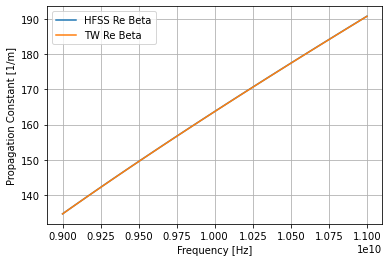

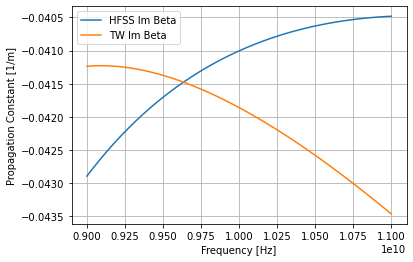

In [2]:
# Waveguide design
L=60e-3
a=22.86e-3
b=3.166e-3
n_wg=sqrt(1.04*(1-0.0003j))
WG=geom.Waveguide(a,b,n_wg,L)
WG.N_modes=2

(BetaRe,f_hfss)=IO.ImportHFSS_Data('../HFSS/BetaRe_DukeCell.csv')
(BetaIm,f_hfss)=IO.ImportHFSS_Data('../HFSS/BetaIm_DukeCell.csv')
beta_hfss=BetaRe-1j*BetaIm

beta=np.zeros(np.shape(f_hfss),dtype=complex)
for i,f0 in enumerate(f_hfss):
    Mode=emag.WaveguideMode(WG,f0)
    beta[i]=Mode.beta


plt.close(0)
plt.figure(0)
plt.plot(f_hfss,np.real(beta_hfss),label='HFSS Re Beta')
plt.plot(f_hfss,np.real(beta),label='TW Re Beta')
plt.ylabel('Propagation Constant [1/m]')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()

plt.close(1)
plt.figure(1)
plt.plot(f_hfss,np.imag(beta_hfss),label='HFSS Im Beta')
plt.plot(f_hfss,np.imag(beta),label='TW Im Beta')
plt.ylabel('Propagation Constant [1/m]')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()

# Polarizability Extraction

In [3]:
# Data files for polarizability extraction
S11MagFile='../HFSS/S11mag_DukeCell_CapSweep.csv'
S11PhaseFile='../HFSS/S11phase_DukeCell_CapSweep.csv'
S21MagFile='../HFSS/S21mag_DukeCell_CapSweep.csv'
S21PhaseFile='../HFSS/S21phase_DukeCell_CapSweep.csv'
HFSS_Files={'S11Mag':S11MagFile,'S11Phase':S11PhaseFile,
            'S21Mag':S21MagFile,'S21Phase':S21PhaseFile}

# Waveguide design
L=60e-3
a=22.86e-3
b=3.166e-3
n_wg=sqrt(1.04*(1-0.0003j))
WG=geom.Waveguide(a,b,n_wg,L)
WG.N_modes=2

# Create dipole
r0=xhat*4.84e-3+yhat*0+zhat*L/2
dip=emag.Dipole(r0)

# Add dipole to geometries
WG.add_dipole(dip)
HS.add_dipole(dip)

# Now, position it where you want it in space
R=math.RotTensor(pi/2,'x',vec_space)
WG.Rotate(R)

# Plot geometry
mlab.init_notebook()
mlab.clf(figure=1)
WG.MayaviPlot(1,plot_fields=False)
PlotTools.MayaviAxes(10,-L/3,L/3,0,L,-L/10,L/2)
mlab.figure(figure=1,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))


Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

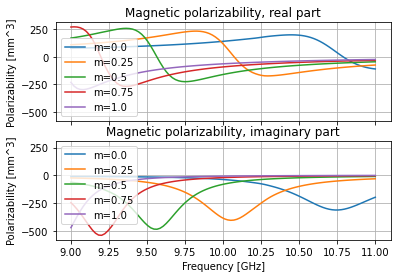

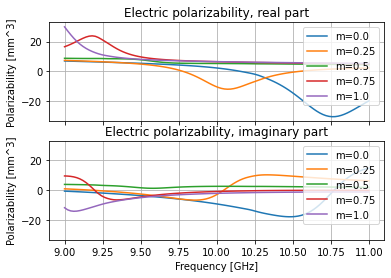

In [4]:
# Extract and check that polarizability extraction is sensible
dip.extract(WG,HFSS_Files,parameterized=1)
f=np.linspace(9e9,11e9,100)
dip.analyze(f,np.linspace(0,1,5))

# Check single-element radiation efficiency and self-consistency of S-parameters

In [5]:
f=np.linspace(9e9,11e9,100)
S11=np.zeros(np.shape(f),dtype=complex)
S21=np.zeros(np.shape(f),dtype=complex)
Prad=np.zeros(np.shape(f),dtype=complex)

m0=0.5
for i, f0 in enumerate(f):
    dip.tune(f0,m0)                         # tune dipole 
    WG.Source(f0,source_type='mode')        # Define source
    
    # Compute
    WG.Compute(f0,compute_type='single_scattering',DeEmbedPort1=L/2,DeEmbedPort2=L/2)
    HS.ComputeFarField(f0)
    Prad[i]=HS.FarField.Prad
    S11[i]=WG.S11
    S21[i]=WG.S21

(0.0, 1.0)

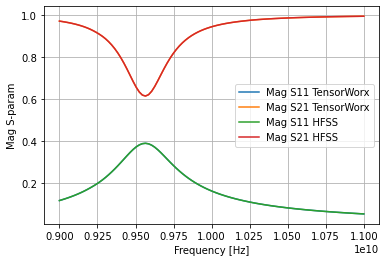

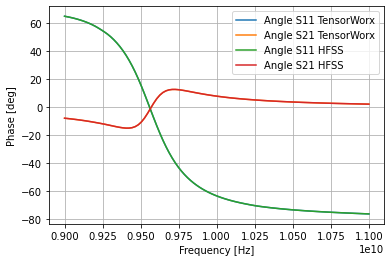

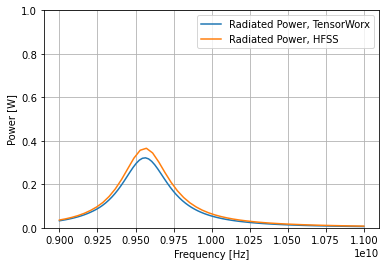

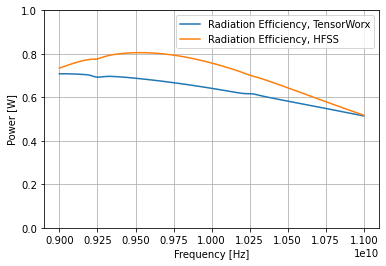

In [6]:
#%% Load HFSS data for comparison
(S11_data,S21_data,f_hfss,param_hfss)=IO.Import_SParams_Parameterized(HFSS_Files)
f_hfss=f_hfss[:,0]
param_hfss=param_hfss[0,:]
S11_hfss_fun_re=scipy.interpolate.RectBivariateSpline(f_hfss,param_hfss,np.real(S11_data))
S11_hfss_fun_im=scipy.interpolate.RectBivariateSpline(f_hfss,param_hfss,np.imag(S11_data))
S21_hfss_fun_re=scipy.interpolate.RectBivariateSpline(f_hfss,param_hfss,np.real(S21_data))
S21_hfss_fun_im=scipy.interpolate.RectBivariateSpline(f_hfss,param_hfss,np.imag(S21_data))
S11_hfss=S11_hfss_fun_re(f,dip.ParameterFunction(m0))+1j*S11_hfss_fun_im(f,dip.ParameterFunction(m0))
S21_hfss=S21_hfss_fun_re(f,dip.ParameterFunction(m0))+1j*S21_hfss_fun_im(f,dip.ParameterFunction(m0))
(Prad_hfss,f_hfss_prad)=IO.ImportHFSS_Data('../HFSS/RadiatedPower_DukeCell.csv')
(EtaRad_hfss,f_hfss_etarad)=IO.ImportHFSS_Data('../HFSS/RadiationEfficiency_DukeCell.csv')


# Plotting
plt.close(0)
plt.figure(0)
plt.plot(f,np.abs(S11),label='Mag S11 TensorWorx')
plt.plot(f,np.abs(S21),label='Mag S21 TensorWorx')
plt.plot(f,np.abs(S11_hfss),label='Mag S11 HFSS')
plt.plot(f,np.abs(S21_hfss),label='Mag S21 HFSS')
plt.ylabel('Mag S-param')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()

plt.close(1)
plt.figure(1)
plt.plot(f,np.angle(S11)*180/pi,label='Angle S11 TensorWorx')
plt.plot(f,np.angle(S21)*180/pi,label='Angle S21 TensorWorx')
plt.plot(f,np.angle(S11_hfss)*180/pi,label='Angle S11 HFSS')
plt.plot(f,np.angle(S21_hfss)*180/pi,label='Angle S21 HFSS')
plt.legend()
plt.grid()
plt.ylabel('Phase [deg]')
plt.xlabel('Frequency [Hz]')

plt.close(2)
plt.figure(2)
plt.plot(f,np.real(Prad),label='Radiated Power, TensorWorx')
plt.plot(f_hfss_prad,Prad_hfss,label='Radiated Power, HFSS')
plt.grid()
plt.legend()
plt.ylabel('Power [W]')
plt.xlabel('Frequency [Hz]')
plt.ylim(0,1)

plt.close(3)
plt.figure(3)
plt.plot(f,np.real(Prad)/(1-np.abs(S21)**2-np.abs(S11)**2),label='Radiation Efficiency, TensorWorx')
plt.plot(f_hfss_etarad,EtaRad_hfss,label='Radiation Efficiency, HFSS')
plt.grid()
plt.legend()
plt.ylabel('Power [W]')
plt.xlabel('Frequency [Hz]')
plt.ylim(0,1)

# Build 15-element waveguide model

In [7]:
#%% 
# Fresh waveguide and half-space
pitch=6.7e-3
N=15
L=N*pitch+0.03
a=22.86e-3
b=3.166e-3
n_wg=sqrt(1.04*(1-0.0003j))
WG=geom.Waveguide(a,b,n_wg,L)
WG.N_modes=10
HS=geom.HalfSpace()

# Now, position it where you want it in space
R=math.RotTensor(pi/2,'x',vec_space)
WG.Rotate(R)

# Dipole array design, based off of copying our original dipole which already has an extracted polarizability
x1=dip.r0[xhat]
x2=a-x1
y_pos=np.arange(0,N*pitch,pitch)+30e-3
x_pos=np.asarray([x2*int(i%2==0)+x1*int(i%2==1) for i in range(1,N+1)])
z_pos=np.ones(np.shape(y_pos))*dip.r0[zhat]
r_pos=math.GridToListOfVectors({xhat:x_pos,yhat:y_pos,zhat:z_pos})
dip_array=dip.Array(r_pos)

for dipole in dip_array:
    WG.add_dipole(dipole)
    HS.add_dipole(dipole)

# Plot geometry
mlab.init_notebook()
mlab.clf(figure=2)
WG.MayaviPlot(1,plot_fields=False)
PlotTools.MayaviAxes(10,-L/3,L/3,0,L,-L/10,L/2)
mlab.figure(figure=2,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))


Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

# Modulate and solve

In [8]:
# Modulation
f0=9.7347e9
ts1=np.asarray([25,20,17,14, 9, 1,25,18,15,13,11, 7,25,18,18])
ts4=np.asarray([25,20, 4, 2,25,20,19, 6, 1,24,17, 9, 3,25,22])
mod=(ts4-1)/24
for i,dipole in enumerate(dip_array):
    dipole.tune(f0,mod[i])

# Solve
WG.Source(f0)
WG.Compute(f0,compute_type='coupled')
HS.ComputeFarField(f0)

# Plot near fields
mlab.init_notebook()
mlab.clf(figure=3)
WG.MayaviPlot(1,plot_fields=True,field_clip=30,phase=1.08*pi)
PlotTools.MayaviAxes(10,-L/3,L/3,0,L,-L/10,L/2)
mlab.figure(figure=3,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [15]:
# 3D Far field plotting
directivity=HS.FarField.directivity
k=HS.FarField.k
(theta_grid,phi_grid,th_axis,ph_axis,dth,dph)=math.HalfSphereGrid(360,90)
Dir_dB=10*np.log10(np.real(directivity(k(theta_grid,phi_grid)))+1e-16) 
Dir_dB[Dir_dB<0]=0
rhat=math.SphericalBasis('r')
X=Dir_dB*(rhat.dot(xhat))(theta_grid,phi_grid)
Y=Dir_dB*(rhat.dot(yhat))(theta_grid,phi_grid)
Z=Dir_dB*(rhat.dot(zhat))(theta_grid,phi_grid)
mlab.init_notebook()
mlab.clf(figure=4)
mlab.mesh(X,Y,Z)
coordmax=np.max([X,Y,Z])
PlotTools.MayaviAxes(10,-coordmax,coordmax,-coordmax,coordmax,0,coordmax)
mlab.figure(figure=4,bgcolor=(1,1,1), fgcolor=(0.,0.,0.))

Notebook initialized with ipy backend.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

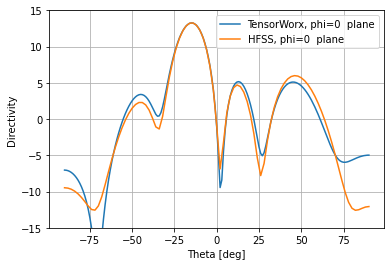

In [16]:
data=pd.read_csv('../HFSS/DirectivitySlice_DukeCell.csv').to_numpy()
f_hfss=data[:,0]*1e9
phi_hfss=data[:,2]
Dir_dB_hfss=data[:,-1]
# Far field plotting
directivity=HS.FarField.directivity
k=HS.FarField.k
# (theta_grid,phi_grid,th_axis,ph_axis,dth,dph)=math.HalfSphereGrid(360,90)
phi_grid=np.linspace(-pi/2,pi/2,181)
theta_grid=pi/2*np.ones(np.shape(phi_grid))
Dir_dB=10*np.log10(np.real(directivity(k(theta_grid,phi_grid)))+1e-16) 
plt.close(1)
plt.figure(1)
plt.plot(phi_grid*180/pi,np.squeeze(Dir_dB),label='TensorWorx, phi=0  plane') 
plt.plot(phi_hfss,np.squeeze(Dir_dB_hfss),label='HFSS, phi=0  plane') 
plt.ylim(-15,15)
plt.grid()
plt.ylabel('Directivity')
plt.xlabel('Theta [deg]')
plt.legend()

In [17]:
print('Peak Directivity = '+'%2.2f dBi' % np.max(Dir_dB))
print('Radiated Power = '+'%2.1f%%' % (HS.FarField.Prad*100))
print('Accepted Power = '+'%2.1f%%' % ((1-np.abs(WG.S21)**2-np.abs(WG.S11)**2)*100))
print('Radiation Efficiency = '+'%2.1f%%' % (HS.FarField.Prad/(1-np.abs(WG.S21)**2-np.abs(WG.S11)**2)*100))

Peak Directivity = 13.27 dBi
Radiated Power = 44.6%
Accepted Power = 55.5%
Radiation Efficiency = 80.3%
